<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/GP15_Defining_Watermass_Subtypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install py_pcha
!pip install gsw

     |████████████████████████████████| 2.4MB 17.8MB/s 


Grab the data

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1O869bUhoTrPCW4hDaSVswLiQ7vzhzIlP' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2021-05-04 02:31:04--  https://docs.google.com/uc?export=download&id=1O869bUhoTrPCW4hDaSVswLiQ7vzhzIlP
Resolving docs.google.com (docs.google.com)... 142.250.81.206, 2607:f8b0:4004:82f::200e
Connecting to docs.google.com (docs.google.com)|142.250.81.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uot9igrm5lk2i76mt1iimc2pv96vmvmf/1620095400000/06203730782251856755/*/1O869bUhoTrPCW4hDaSVswLiQ7vzhzIlP?e=download [following]
--2021-05-04 02:31:05--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uot9igrm5lk2i76mt1iimc2pv96vmvmf/1620095400000/06203730782251856755/*/1O869bUhoTrPCW4hDaSVswLiQ7vzhzIlP?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 142.251.33.193, 2607:f8b0:4004:837::2001
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googl

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
import gsw

Read in the data frame and rename the columns

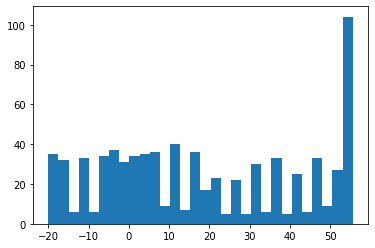

In [29]:
df = pandas.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv", na_values = -999)

plt.hist(df["lat"], bins=30)
plt.show()

In [18]:
filter_conditions = {
    "AAIW": {"lat_min":-51.0, "lat_max":-47.0,
             "lon_min":-120.0, "lon_max":150.0,
             "sig0_min":27.01, "sig0_max":27.1}
}

def filter_rows(lat_min, lat_max, lon_min, lon_max, sig0_min, sig0_max):
  return remapnames_df[(remapnames_df["lat"] >= lat_min) &
                       (remapnames_df["lat"] <= lat_max) #&
                       #(remapnames_df["lon"] >= lon_min) &
                       #(remapnames_df["lon"] <= lon_max) &
                       #(remapnames_df["sig0"] >= sig0_min) &
                       #(remapnames_df["sig0"] >= sig0_max)
                       ]
                       
AAIW_rows = filter_rows(**filter_conditions["AAIW"])

In [19]:
AAIW_rows

,stnnbr,geotrc_ID,lat,lon,depth,pres,temp,salinity,oxygen,silicate,nitrate,phosphate,sig0,PO,NO,pt
